In [1]:
import numpy as np
from scipy import linalg
from tensorly import *
import matplotlib.pyplot as plt

In [2]:
TENSOR_ORDER = 3
CORE_TENSOR_SHAPE = (2, 2, 2)
factors = [] # not a HOSVD initilization
tensor = np.random.rand(3,3,3)
np.random.seed(1)

### Important interpretation

---

Each entry of a numpy tensor is of the form $X_{IJK}$, but while printing the tensor, it does not print the tensor sheet ($k$) wise. Instead it prints in the indexing order. So the sheets you will see will be first row level sheets $i$ and then $j$ level and then $k$ level sheets.

In [3]:
X  = np.arange(24).reshape(3,4,2) # row, col, depth (your choice your interpretation)
print(X)

[[[ 0  1]
  [ 2  3]
  [ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]
  [12 13]
  [14 15]]

 [[16 17]
  [18 19]
  [20 21]
  [22 23]]]


In [4]:
print(X[2][2][1]) # k, i, j indexing according to the picure here

21


In [5]:
print(X[...,1])

[[ 1  3  5  7]
 [ 9 11 13 15]
 [17 19 21 23]]


In [6]:
unfolded = unfold(X, 0) # mode 1 matricization of the tensor
print(unfolded)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]]


In [7]:
print(X.reshape(-1, 3, order='F'))

[[ 0 20 11]
 [ 8  6 19]
 [16 14  5]
 [ 2 22 13]
 [10  1 21]
 [18  9  7]
 [ 4 17 15]
 [12  3 23]]


In [8]:
class CP:
    def __init__(self, tensor, rank, max_iter=100, eps=1):
        """
        PARAFAC decompositon, it initializes the maximum amount of iterations that 
        are done along with the tolerance value for the convergence
        it also takes the size of the core tensor `rank`
        """
        self.tensor = tensor
        self.rank = rank
        self.max_iter = max_iter
        self.eps = eps
        self.prod_norms = []
        self.prod_kr_norms = []
        self.factor_update_norms = []
        self.core_norms = []
        self.errors = []
        self.factors = []
        self.core = np.zeros(CORE_TENSOR_SHAPE)

        np.fill_diagonal(self.core, 1)
         
    def fit(self):
        self._init_factors()
        for i in range(self.max_iter):
            for mode in range(TENSOR_ORDER):
                self._update_factors(mode)
            if self._is_converged():
                break
        print("Converged in {} iterations".format(i))
        print("Final error = ", self.errors[-1])
        
    def _init_factors(self):
        """
        initialize the factors using the `rank` many left singular 
        vectors of the corresponding mode-n matricization of the input tensor
        """
        matricized = [unfold(self.tensor, mode) for mode in range(TENSOR_ORDER)]
        self.factors = [linalg.svd(matrix, full_matrices=False)[0][:, :self.rank] for matrix in matricized]
        print("Initialized factors")
        pass
    
    def _update_factors(self, mode):
        """
        Update the factors per iteration for the `mode`'th Factor
        """
        # compute hadamard product of the gram matrices of other factors
        prod = np.ones((self.rank, self.rank))
        for pos in reversed(range(TENSOR_ORDER)):
            if(mode != pos):
                prod = np.multiply(prod, self.factors[pos].T @ self.factors[pos])
        self.prod_norms.append(np.linalg.norm(prod))
        # compute the Khatri-Rao product of the other factors
        prod_kr = np.ones((1, self.rank))
        for pos in reversed(range(TENSOR_ORDER)):
            if(mode != pos):
                prod_kr = linalg.khatri_rao(prod_kr, self.factors[pos])
        
        self.prod_kr_norms.append(np.linalg.norm(prod_kr))
        
        W = unfold(self.tensor, mode) @ prod_kr
        
        # now solve the least squares problem
        self.factors[mode] = W @ np.linalg.pinv(prod)
        # now normalize the factor and update the core tensor
        col_norms = np.linalg.norm(self.factors[mode], axis=0)
        self.factor_update_norms.append(np.linalg.norm(col_norms))
        self.factors[mode] = self.factors[mode] / col_norms
        norm_identity = np.zeros(CORE_TENSOR_SHAPE)
        np.fill_diagonal(norm_identity, col_norms)
        self.core = self.core * norm_identity
        self.core_norms.append(np.linalg.norm(self.core))
        pass
    
    def _is_converged(self):
        """
        check if the algorithm has converged
        by computing the Frobenius norm of the difference between the current tensor
        and the tensor obtained by multiplying the factors
        """
        # intitialize the core identitiy tensor
        

        # print(core)
        estim = tenalg.multi_mode_dot(self.core, self.factors)
        error = np.linalg.norm(self.tensor - estim)
        print("Error = ", error)
        self.errors.append(error)
        return error < self.eps
    
    def plot_errors(self):
        # plt.plot(self.errors)
        plt.plot(self.prod_norms)
        plt.plot(self.prod_kr_norms)
        plt.plot(self.factor_update_norms)
        # plt.plot(self.core_norms)
        plt.legend(["Prod Norms", "Prod KR Norms", "Factor Update Norms", "Core Norms"])
        plt.xlabel("Iterations")
        plt.ylabel("Frobenius norm")
        plt.show()
        
        
        

In [9]:
for pos in reversed(range(TENSOR_ORDER)):
    print(pos)

2
1
0


In [10]:
decomp = CP(tensor, rank=2)


In [11]:
decomp.fit()

Initialized factors
Error =  13.66437596432516
Error =  269.7240602540016
Error =  4505.686425572937
Error =  77842.44976961265
Error =  1345571.6458673466
Error =  23592376.181847107
Error =  430609576.5798543
Error =  8516936846.409652
Error =  179101031906.37558
Error =  3319154837765.5396
Error =  42176115554799.3
Error =  482891384950597.6
Error =  2646922882310542.5
Error =  2.289613625230726e+16
Error =  8.30645760469244e+16
Error =  4.5218883068289384e+19
Error =  3.33347004336328e+22
Error =  5.450602295151348e+25
Error =  3.4430415464884596e+28
Error =  6.294914550252423e+31
Error =  1.2795246590064237e+35
Error =  9.30244153656356e+37
Error =  6.620106884960272e+40
Error =  6.247572351434139e+43
Error =  1.9316019477386188e+46
Error =  5.3451572766466225e+48
Error =  1.9309771586435837e+51
Error =  2.60534311284874e+53
Error =  3.3660040759518317e+55
Error =  3.511427787408815e+57
Error =  3.947088684967443e+58
Error =  9.336513882122756e+60
Error =  1.1039267765352853e+65
E

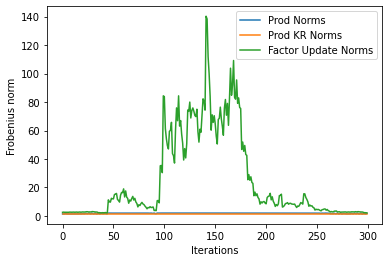

In [12]:
decomp.plot_errors()

In [13]:
decomp.prod_norms
decomp.prod_kr_norms
decomp.factor_update_norms

[2.5445046245887113,
 2.6686848452869167,
 2.57301597850227,
 2.5623666435259307,
 2.594702832707064,
 2.6163876039412206,
 2.5604547290977435,
 2.683906242979129,
 2.632105566553861,
 2.612668535118307,
 2.690433567050336,
 2.697838187326171,
 2.6011923694102785,
 2.670918165993628,
 2.7204061347941426,
 2.591899042969772,
 2.6727196660115573,
 2.752395323971083,
 2.6146512250012264,
 2.693336440991788,
 2.8116860127647922,
 2.7030905045377756,
 2.752082800244264,
 2.89345880410209,
 2.971943297011478,
 2.8383394821064716,
 2.750834439768827,
 2.8433981856815933,
 2.7374255032507517,
 3.0468393334033834,
 3.0006646752077217,
 2.8690895564176424,
 2.7812739304142564,
 2.7282558833628947,
 2.7039671496304205,
 2.2922768773966666,
 2.3100612547785295,
 2.233552882687827,
 2.1595054217070064,
 2.2773430735572435,
 2.2208181625890617,
 2.2115024552105034,
 2.3752416856008267,
 2.195693943444427,
 2.2297807193796695,
 11.288048343875456,
 9.893347584428918,
 9.700209646906007,
 12.390376007